<a href="https://colab.research.google.com/github/JulianSchmidtke/CAPTUM/blob/main/AsuD_CAPTUM_v0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import nltk, os
import pandas as pd
import numpy as np
import re
from collections import Counter
import shutil

In [5]:
os.chdir(r'/content')

content_dir = r'/content/CAPTUM/'

# Remove if files already exist
while os.path.exists(content_dir): 
    shutil.rmtree(content_dir)


!git clone https://github.com/JulianSchmidtke/CAPTUM.git

Cloning into 'CAPTUM'...
remote: Enumerating objects: 529, done.
remote: Counting objects: 100% (529/529), done.
remote: Compressing objects: 100% (506/506), done.
remote: Total 529 (delta 37), reused 463 (delta 20), pack-reused 0
Receiving objects: 100% (529/529), 11.45 MiB | 9.72 MiB/s, done.
Resolving deltas: 100% (37/37), done.


# Duplikate unter den Papern entfernen anhand der Hash-Werte

In [7]:
#Arbeitsverzeichnis auf das Ordnerverzeichnis ändern, in welchem die Daten liegen (txt-Format)
file_dir = r'/content/CAPTUM/files'
os.chdir(file_dir)

#Speichern der Dateinamen in einem Array
files = os.listdir()
df_files = pd.DataFrame(files, columns=['Filepath'])

,Filepath
0,CAPTUM_BAT_BHRA_Swerdt 2005.pdf_out_text.txt
1,CAPTUM_BAT_Cyclosporine_Grattan 2000.pdf_out_t...
2,CAPTUM_Severity_Duration_Arik yilmaz 2017.pdf_...
3,CAPTUM_Angioedema_Omalizumab_Maurer 2016 .pdf_...
4,CAPTUM_Severity_Omalizumab_Metz 2018.pdf_out_t...
...,...
1041,CAPTUM_Eosinophil_Basophil_Uysal 2016.pdf_out_...
1042,CAPTUM_Total IgE_D-Dimer_Asero 2019.pdf_out_te...
1043,CAPTUM_ASST_Allergic Diseases_Chen 2016.pdf_o...
1044,CAPTUM_ASST_CRP_Montjoye 2020.pdf_out_text.txt


In [8]:
# create checksum for each file to identify duplicates
# https://stackoverflow.com/questions/16874598/how-do-i-calculate-the-md5-checksum-of-a-file-in-python#16876405
import hashlib
def get_checksum(filepath: str) -> str:
    # Open,close, read file and calculate MD5 on its contents 
    with open(filepath, 'rb') as file_to_check:
        # read contents of the file
        data = file_to_check.read()    
        # pipe contents of the file through
        return hashlib.md5(data).hexdigest()
df_files['Checksum'] = df_files['Filepath'].apply(get_checksum)

In [9]:
fileNameTags = list(map(lambda fn: fn.replace('', '+').split('_')[0:-2],df_files['Filepath']))


df_files['Name'] = [fNT[-1] for fNT in fileNameTags]
df_files['Tags'] = [fNT[1:-1] for fNT in fileNameTags]
df_files['Year'] = [fY[-8:-4] for fY in df_files['Name']]
df_files['Authors'] = [fN.split(' ')[0] for fN in df_files['Name']]

In [10]:
#Den Inhalt der Paper einlesen und in einen Pandas-
df_files['Content'] = df_files['Filepath'].apply(lambda f: open(f, 'r', encoding = "ISO-8859-1").read())
df_files

,Filepath,Checksum,Name,Tags,Year,Authors,Content
0,CAPTUM_BAT_BHRA_Swerdt 2005.pdf_out_text.txt,cfc0bafeca8e44c8ae4b20db99d3f4d8,Swerdt 2005.pdf,"[BAT, BHRA]",2005,Swerdt,youpuap AB1a]|p poo\n\nS\nw\no\na\nw\n®\nY\na...
1,CAPTUM_BAT_Cyclosporine_Grattan 2000.pdf_out_t...,79e96f4baf3415f2597f79f00d86d3b1,Grattan 2000.pdf,"[BAT, Cyclosporine]",2000,Grattan,British Journal of Dermatology 2000; 143: 365-...
2,CAPTUM_Severity_Duration_Arik yilmaz 2017.pdf_...,edb8e044a0018d41eeaad404dc4ee498,Arik yilmaz 2017.pdf,"[Severity, Duration]",2017,Arik,The persistence of chronic spontaneous urticar...
3,CAPTUM_Angioedema_Omalizumab_Maurer 2016 .pdf_...,cf4d0c262fc8cccde7c7dbf63093f221,Maurer 2016 .pdf,"[Angioedema, Omalizumab]",016,Maurer,Received Date: 29-Sep-2016\nAccepted Date: 22-...
4,CAPTUM_Severity_Omalizumab_Metz 2018.pdf_out_t...,d6fa683062ac6c499d450bc62fe38ecc,Metz 2018.pdf,"[Severity, Omalizumab]",2018,Metz,Check for\nupdates\n\nPROF. MARCUS MAURER (Orc...
...,...,...,...,...,...,...,...
1041,CAPTUM_Eosinophil_Basophil_Uysal 2016.pdf_out_...,a86431127af09c8de0863de2f261a361,Uysal 2016.pdf,"[Eosinophil, Basophil]",2016,Uysal,198\n\nOriginal Articl¢\n\n \n\nTURK A\nPEDIAT...
1042,CAPTUM_Total IgE_D-Dimer_Asero 2019.pdf_out_te...,c7b5ca323305000a835fc3260b1ea077,Asero 2019.pdf,"[Total IgE, D-Dimer]",2019,Asero,ORIGINAL ARTICLE\n\nEur ANN ALLERGY CLIN IMMUN...
1043,CAPTUM_ASST_Allergic Diseases_Chen 2016.pdf_o...,2fa8166af1abbc7c11e4209a5a68a996,Chen 2016.pdf,"[ASST+, Allergic Diseases]",2016,Chen,Received Date: 13-Jan-2016\nAccepted Date: 18-...
1044,CAPTUM_ASST_CRP_Montjoye 2020.pdf_out_text.txt,5492f2ac1e413b91c6c99d02d3bbbd28,Montjoye 2020.pdf,"[ASST+, CRP]",2020,Montjoye,"Correlations between disease activity, autoimm..."


In [11]:
checksums = df_files['Checksum'].unique()
for checksum in checksums:
    tags = df_files.loc[df_files['Checksum'] == checksum, 'Tags']
    list_of_pair_of_tags = tags.values.ravel()
    list_of_tags = [tag for tags in list_of_pair_of_tags for tag in tags]
    unique_tags = pd.unique(list_of_tags)
    df_files.loc[df_files['Checksum'] == checksum, 'Tags'] = ', '.join(map(str, unique_tags))

In [12]:
# create dataframe for further analytics w/o the duplicate articles
df = df_files.drop_duplicates(subset=['Checksum'], keep='first')
df.reset_index(inplace=True, drop=True)
df = df.loc[:,['Authors','Year','Tags', 'Content']]

# Korpus erstellen

In [13]:
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Es werden Füllwörter entfernt.

In [15]:
stop_words=set(stopwords.words("english"))
def stoppingFunc(text, stop_words=stop_words):
    filtered_text=[]
    for word in text:
        # Wort unter 3 Zeichen -> weg
        if len(word) < 3:
          next
        # Mehr als eine Ziffer -> weg
        elif sum(c.isdigit() for c in word)>1:
          next
        # nicht in Stopword Liste -> behalten
        elif word not in stop_words:
          filtered_text.append(word)
        
    return filtered_text

Wörter auf ihren Wortstamm reduzieren (cats -> cat, transportation -> transport)

In [16]:
def stemmingFunc(text):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in text]

Komplexere Version des Stemming. Wörter werden im Zusammenhang gesehen und reduziert. Verben werden auf den Infiitiv gesetzt usw.

In [17]:
def lemmatizingFunc(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

In [18]:
def removeWords(text):
  filtered_text=[]
  for word in text:
    if word.lower() in ('csu', 'urticaria', 'doi', 'http', 'the', 'al'):
      next
    else:
      filtered_text.append(word)

  counter = Counter(filtered_text)
  filtered_text = [key for key, val in counter.items() if val > 1]

  return filtered_text

In [19]:
def remove_doi(text):
  doi_regex = r"10.\d{4,9}\/[-._;()\/:A-Z0-9]+$"
  new_text = re.sub(doi_regex, '', text, flags=re.IGNORECASE)
  return new_text

In [20]:
removeWords(['csu', 'TEST', 'DOI', 'doi', 'al', 'DOI'])

['DOI']

In [21]:
def normalize_text(tokenizer, text):
  # lowercase text
  text = str(text).lower()
  # remove non-UTF
  text = text.encode("utf-8", "ignore").decode()
  # remove doi
  text = remove_doi(text)

  tokenized_text = tokenizer.tokenize(text)

  tokenized_text = removeWords(tokenized_text)
  tokenized_text = stoppingFunc(tokenized_text)
  #tokenized_text = stemmingFunc(tokenized_text)
  tokenized_text = lemmatizingFunc(tokenized_text)

  text = " ".join(tokenized_text)
  return text

Ich glaube es sollte entweder eine Stemming oder eine Lemmatizing Funktion angewendet werden.

Ich glaube wir sollten erst Lemmatizen und dann Stopwords entfernen.

In [22]:
regex_tokenizer = nltk.RegexpTokenizer("\w+")
df['Corpus'] = df['Content'].apply(lambda c: normalize_text(regex_tokenizer, c))


regex_tokenizer2 = nltk.RegexpTokenizer('\w+[\.,]{0,1}')
df['Corpus_w_Punctuation'] = df['Content'].apply(lambda c: normalize_text(regex_tokenizer2, c))

In [23]:
df

,Authors,Year,Tags,Content,Corpus,Corpus_w_Punctuation
0,Swerdt,2005,"BAT, BHRA, Basophil, Severity, Angioedema",youpuap AB1a]|p poo\n\nS\nw\no\na\nw\n®\nY\na...,sixd detection basophil activating igg autoant...,sixd detection basophil activating igg autoant...
1,Grattan,2000,"BAT, Cyclosporine, BHRA, Severity, Basophil, A...",British Journal of Dermatology 2000; 143: 365-...,british journal dermatology randomized double ...,british journal dermatology randomized double ...
2,Arik,2017,"Severity, Duration, Allergic Diseases, Angioedema",The persistence of chronic spontaneous urticar...,persistence chronic spontaneous childhood asso...,persistence chronic spontaneous childhood asso...
3,Maurer,016,"Angioedema, Omalizumab",Received Date: 29-Sep-2016\nAccepted Date: 22-...,received date accepted article positive impact...,received date accepted article positive impact...
4,Metz,2018,"Severity, Omalizumab",Check for\nupdates\n\nPROF. MARCUS MAURER (Orc...,marcus maurer article type experimental allerg...,marcus maurer article type experimental allerg...
...,...,...,...,...,...,...
449,Sterba,2015,"anti-FcεRI, Basophil",jduosnueyy souiny yduosnueyy soulny jduosnueyy...,jduosnueyy souiny yduosnueyy soulny souyny aut...,jduosnueyy souiny yduosnueyy soulny souyny aut...
450,Nada,2020,"Duration, Angioedema",| ®\nAccepted: 11 September 2020.\n\nCheck for...,received jocd contribution wiley dermatology i...,received jocd. contribution wiley dermatology ...
451,Saini,2017,"Basophil, Omalizumab",Accepted Manuscript\n\nJOURNAL OF INVESTIGATIV...,accepted manuscript journal investigative derm...,accepted manuscript journal investigative derm...
452,Ferrer,2017,"Severity, Omalizumab",doi:10.1684/ejd.2017.3085\n\nReview\n\nMarta F...,ejd review marta ferrer isabelle boccon gibod ...,ejd. review marta ferrer isabelle boccon gibod...


### Distinct Tags

In [24]:
type(list(df['Tags']))
tags = set(', '.join(list(df['Tags'])).split(', '))
print(*tags, sep="\n")

Omalizumab
ANA
anti-TPO IgE ratio+
CRP
Antihistamine
dsDNA
Ana
Allergic Diseases
anti-FcεRI
Cyclosporine
BHRA
Basophil count
Eosinophil
duration
Anti-IgE
Basophil
serverity+
thyroglobulin
Duration
angioedema
ASST+
Angioedema
Tissue factor
BAT
cyclosporine
omalizumab
Severity
IL-24
D-Dimer
Eosinophil count
Thyroglobulin
Total IgE
TPO


# Algorithmen anwenden

## Bag of Words
Quelle: [towardsdatascience](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)

In [35]:
import gensim
import numpy as np
np.random.seed(2021)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [36]:
processed_docs = df['Corpus'].apply(lambda c: c.split(' '))

In [37]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 aaa
1 accordance
2 activated
3 activates
4 activating
5 activation
6 activity
7 affinity
8 age
9 allergen
10 allergy


### **LDA** (LatentDirichletAllocation) 
Quelle: [Medium-Artikel zu LDA](https://towardsdatascience.com/nlp-with-lda-latent-dirichlet-allocation-and-text-clustering-to-improve-classification-97688c23d98)

In [ ]:
#Turn tags into a set for faster checking of whether a tag exists or not
type(list(df['Tags']))
unique_tags = set(', '.join(list(df['Tags'])).split(', '))
print(*unique_tags, sep="\n")


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA


def find_topics(text):
  count_vectorizer = CountVectorizer()
  count_data = count_vectorizer.fit_transform(list(text))


  # One topic that has an avg of two words because most questions had 1/2 tags
  number_topics = 5
  number_words = 20

  # Create and fit the LDA model
  lda = LDA(n_components=number_topics, n_jobs=-1)
  lda.fit(count_data)
  words = count_vectorizer.get_feature_names()

  #Get topics from model. They are represented as a list e.g. ['military','army']
  topics = [[words[i] for i in topic.argsort()[:-number_words - 1:-1]] for (topic_idx, topic) in enumerate(lda.components_)]
  topic_groups = topics

  topics = np.array(topics).ravel()
  distinct_topics = list(set(topics))

  #Only use topics for which a tag already exists
  existing_topics = set.intersection(set(topics),unique_tags)

  

  return (words, distinct_topics, topic_groups, existing_topics)

In [ ]:
words, distinct_topics, topic_groups, existing_topics = find_topics(df['Corpus_w_Punctuation'])

In [ ]:
sorted(distinct_topics)


### **BERTopic** 
Topic modeling mit BERTopic -> siehe: https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

Copy and Paste aus: https://colab.research.google.com/drive/1iqs9Y5_zLI6R6mAwlnapcxcUbKjpv2CC?usp=sharing#scrollTo=MgMaef_uZT0T
bzw.: https://www.youtube.com/watch?v=TLPmlVeEf1k

In [29]:
!pip3 install bertopic[all]
from bertopic import BERTopic

^C


ModuleNotFoundError: ignored

In [ ]:
topic_model = BERTopic(language="english", calculate_probabilities=True) # We need the probabilities to visualize
topics, _ = topic_model.fit_transform(list(df['Content']))

In [ ]:
# Get the most frequent topics
topic_freq = topic_model.get_topic_freq()
outliers = topic_freq['Count'][topic_freq['Topic']==-1].iloc[0]
print(f"{outliers} documents have not been classified")
print(f"The other {topic_freq['Count'].sum() - outliers} documents are {topic_freq['Topic'].shape[0]-1} topics")

In [ ]:
topic_freq.head()

In [ ]:
print(f"There are {topic_freq['Count'].iloc[1]} documents that are talking about topic ID {topic_freq['Topic'].iloc[1]}")

In [ ]:
topic_model.get_topic(topic_freq['Topic'].iloc[1])

In [ ]:
topic_model.visualize_topics()

### **DistilBert**
Quelle: https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(df['Content'], show_progress_bar=True)

In [ ]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5,
                            metric='cosine').fit_transform(embeddings)

In [ ]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=4,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [ ]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=20, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=15)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=15, cmap='hsv_r')
plt.colorbar()

### Top2Vec

Quelle: https://github.com/bhattbhavesh91/Top2Vec-Demo/blob/main/Top2Vec-Notebook.ipynb

In [ ]:
!pip install -q numpy
!pip install -q pandas
!pip install -q gensim
!pip install -q pynndescent>=0.4
!pip install -q umap-learn
!pip install -q hdbscan
!pip install -q wordcloud
!pip install -q tensorflow
!pip install -q tensorflow_hub
!pip install -q tensorflow_text
!pip install -q torch
!pip install -q sentence_transformers
!pip install -q hnswlib
!pip install -q joblib<1.0.0
!pip install -q top2vec[sentence_transformers]

In [ ]:
import numpy as np
import pandas as pd
from copy import deepcopy
from top2vec import Top2Vec

In [ ]:
docs = list(df.loc[:, "Content"].values)
docs[:5]

In [ ]:
model = Top2Vec(docs, embedding_model='universal-sentence-encoder')

In [ ]:
model.get_num_topics()

In [ ]:
topic_words, word_scores, topic_nums = model.get_topics(1)

In [ ]:
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

### TFIDF Vertorizer

In [27]:
tfidfconvert = TfidfVectorizer(ngram_range=(1,1)).fit(df.Corpus.values)

In [28]:
len(tfidfconvert.vocabulary_)

15739

In [29]:
words_transformed = tfidfconvert.transform(df.Corpus.values)

### K-Means Clustering

In [30]:
from sklearn.cluster import KMeans

K-Means für mehrere k's berechnen

In [33]:
Sum_of_squared_distances = []
max_range = 25
K = range(1,max_range + 1)
for k in K: 
    print(str(k) + "/" + str(max_range))
    km = KMeans(n_clusters=k)
    km = km.fit(words_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    

1/25
2/25
3/25
4/25
5/25
6/25
7/25
8/25
9/25
10/25
11/25
12/25
13/25
14/25
15/25
16/25
17/25
18/25
19/25
20/25
21/25
22/25
23/25
24/25
25/25


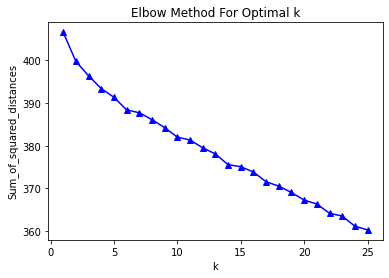

In [34]:
plt.plot(K,Sum_of_squared_distances, 'b^-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()



# **IDEEN zum Cluster bilden**


- Bag of Words kreiren um neuer Cluster / Wortgruppen zu finden über Häufigkeit der Wörter oder nähe der Wörter zu einander
- Visualisieren des Links zwischen Markern in einer HeatMap
- BioBert einsetzen
- Part of Speech recognition um Autorennamen zu identifizieren 
- AutorenNamen und Marker verknüpfen / clustern
- 


**Generelle Todo's**
- Distinct Values für Abkürzungsverzeichnis erheben und mit Markern abgleichen
- CRISP-DM als Vorgehensmoddel zugrundeliegen
- Begründen Stemm / Lemmatizing - Erörterung im Paper